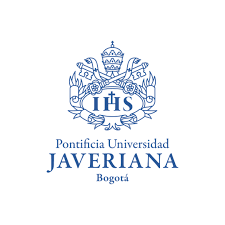

# **Pontificia Universidad Javeriana**

**Mtr. en Analítica para la Inteligencia de Negocios**

**Proyecto Tópicos avanzados en analítica**

Estudiantes

*Cesar Ramírez Gómez*

*Maria Fernanda Caicedo*

# **1.Librerias requeridas**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install demoji
!pip install unidecode
!pip install sentiment-analysis-spanish
!python -m spacy download es_core_news_sm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
plt.style.use('ggplot')
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import string
import re
from string import digits
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import demoji
import unidecode
from nltk.tokenize import sent_tokenize, word_tokenize
from sentiment_analysis_spanish import sentiment_analysis
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('es_core_news_sm')
nltk.download('stopwords')
nltk.download('punkt')

2023-09-29 16:06:40.228429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 16:06:41.113194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 69.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **2.Cargue Modelos clasificacion**

In [3]:
# Cargar el modelo de prediccion categoria
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/Universidad/Analitica_NPL/Proyecto/modelo_lstm.h5')
# Cargar el vocabulario del tokenizer desde el archivo JSON
with open('/content/drive/MyDrive/Colab_Notebooks/Universidad/Analitica_NPL/Proyecto/word_index.json', 'r', encoding='utf-8') as f:
    word_index = json.loads(f.read())

# Crea un nuevo Tokenizer y asigna el vocabulario cargado
loaded_tokenizer = Tokenizer(num_words=len(word_index) + 1)
loaded_tokenizer.word_index = word_index
max_length = 4166


# **3.Funciones**

In [4]:
def predecir_categoria(input_text, loaded_tokenizer, loaded_model):
    # Tokeniza y realiza el padding del texto de entrada
    input_seq = loaded_tokenizer.texts_to_sequences(input_text)
    input_pad = pad_sequences(input_seq, maxlen=max_length, padding='post', truncating='post')

    # Realiza la predicción
    predictions = loaded_model.predict(input_pad)

    # El resultado es una matriz de probabilidades, puedes obtener la clase predicha así:
    predicted_class = np.argmax(predictions, axis=1)

    clase_a_nombre = {
        0: "politica",
        1: "economia",
        2: "deportes",
        3: "cultura",
        4: "tecnosfera",
        5: "vida"
    }

    # Obtén el nombre de la clase predicha
    predicted_class_name = clase_a_nombre.get(predicted_class[0], "Clase Desconocida")

    return predicted_class_name


In [5]:
def analizar_sentimiento(texto, umbral_positivo=0.7):
    # Inicializar el analizador de sentimientos en español
    analyzer = sentiment_analysis.SentimentAnalysisSpanish()

    # Realizar el análisis de sentimientos en español
    probabilidad_positiva = analyzer.sentiment(texto)

    if probabilidad_positiva >= umbral_positivo:
        polaridad = "Extremadamente Positivo; El artículo no ha sido aceptado por el periódicoX debido a que muestra un sesgo de polaridad."
        bandera_polaridad_resultado = 0
    elif probabilidad_positiva >= umbral_positivo - 0.1:
        polaridad = "Muy Positivo, el artículo ha pasado el filtro de polaridad"
        bandera_polaridad_resultado = 1
    elif probabilidad_positiva >= umbral_positivo - 0.2:
        polaridad = "Positivo, el artículo ha pasado el filtro de polaridad"
        bandera_polaridad_resultado = 1
    elif probabilidad_positiva >= umbral_positivo - 0.3:
        polaridad = "Neutral Positivo, el artículo ha pasado el filtro de polaridad"
        bandera_polaridad_resultado = 1
    elif probabilidad_positiva >= umbral_positivo - 0.4:
        polaridad = "Neutro, el artículo ha pasado el filtro de polaridad"
        bandera_polaridad_resultado = 1
    elif probabilidad_positiva >= umbral_positivo - 0.5:
        polaridad = "Neutral Negativo, el artículo ha pasado el filtro de polaridad"
        bandera_polaridad_resultado = 1
    elif probabilidad_positiva >= umbral_positivo - 0.6:
        polaridad = "Negativo, el artículo ha pasado el filtro de polaridad"
        bandera_polaridad_resultado = 1
    elif probabilidad_positiva >= umbral_positivo - 0.7:
        polaridad = "Muy Negativo, el artículo ha pasado el filtro de polaridad"
        bandera_polaridad_resultado = 1
    else:
        polaridad = "Extremadamente Negativo; El artículo no ha sido aceptado por el periódicoX debido a que muestra un sesgo de polaridad."
        bandera_polaridad_resultado = 0

    return bandera_polaridad_resultado, polaridad, probabilidad_positiva

In [6]:
custom_stopwords = stopwords.words("spanish")

def preprocess_and_tokenize(text):
    # Convertir el texto a minúsculas
    text = text.lower()
    # Eliminar caracteres de salto de línea
    text = re.sub(r'\n', ' ', text)
    # Eliminar números
    text = re.sub(r'\d', ' ', text)
    # Eliminar signos de puntuación
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    # Tokenizar el texto
    tokens = word_tokenize(text, language='spanish')
    # Eliminar stopwords personalizadas
    text_filtered = [word for word in tokens if word not in custom_stopwords]
    # Eliminar números nuevamente después de eliminar stopwords
    text_filtered = [re.sub(r'\d', ' ', w) for w in text_filtered]
    # Unir las palabras procesadas en una cadena final
    final_string = ' '.join(text_filtered)

    # Eliminar emojis
    demoji.download_codes()
    final_string = demoji.replace(final_string, '')

    # Eliminar acentos
    final_string = unidecode.unidecode(final_string)

    # Eliminar caracteres de puntuación y números adicionales
    final_string = re.sub(r'[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~“…”’'), ' ', final_string)
    final_string = re.sub(r'\d+', ' ', final_string)

    # Lematizar y tokenizar el texto
    doc = nlp(final_string)
    lemmatized_tokens = [token.lemma_ for token in doc]
     # Unir los tokens lematizados en un solo texto
    final_text = ' '.join(lemmatized_tokens)

    return final_text

In [7]:
def evaluacion_texto(texto):
    # Limpiar el texto de signos de puntuación y caracteres no alfabéticos
    texto_limpio = re.sub(r'[^a-zA-ZñÑáéíóúÁÉÍÓÚ]', ' ', texto)

    # Tokenizar el texto (dividirlo en palabras)
    palabras_con_stop = nltk.word_tokenize(texto)
    palabras_limpias = nltk.word_tokenize(texto_limpio)

    # Obtener la lista de stopwords en español
    stop_words = set(stopwords.words('spanish'))

    # Calcular el conteo de stopwords y no stopwords
    conteo_stopwords = sum(1 for palabra in palabras_con_stop if palabra.lower() in stop_words)
    conteo_no_stopwords = len(palabras_con_stop) - conteo_stopwords

    # Calcular la métrica de diversidad léxica (tasa de palabras únicas)
    num_palabras_distintas = len(set(palabras_limpias))
    diversidad_lexica = num_palabras_distintas / len(palabras_limpias)

    # Calcular el porcentaje de diversidad léxica
    porcentaje_diversidad_lexica = diversidad_lexica * 100

    # Tokenizar el texto en oraciones y palabras para el Índice de Fernández Huerta
    oraciones_legibilidad_FH = sent_tokenize(texto, language='spanish')
    palabras_legibilidad_FH = word_tokenize(texto, language='spanish')

    # Función para contar las sílabas en una palabra
    def contar_silabas_legibilidad_FH(palabra):
        return len(re.findall(r'[aeiouáéíóú]', palabra, re.IGNORECASE))

    # Calcular el número total de sílabas
    total_silabas_legibilidad_FH = sum(contar_silabas_legibilidad_FH(palabra) for palabra in palabras_legibilidad_FH)

    # Calcular el Índice de Fernández Huerta
    indice_fernandez_huerta_legibilidad_FH = 206.84 - 1.02 * (len(palabras_legibilidad_FH) / len(oraciones_legibilidad_FH)) - 60 * (total_silabas_legibilidad_FH / len(palabras_legibilidad_FH))

    # Aplicar un filtro para asegurarse de que el índice esté entre 0 y 100
    indice_fernandez_huerta_legibilidad_FH = max(0, min(100, indice_fernandez_huerta_legibilidad_FH))

    # Función para determinar la dificultad del texto
    def determinar_dificultad(indice_FH):
        if indice_FH >= 90:
            return "Muy fácil"
        elif indice_FH >= 80:
            return "Fácil"
        elif indice_FH >= 70:
            return "Algo fácil"
        elif indice_FH >= 60:
            return "Normal"
        elif indice_FH >= 50:
            return "Algo difícil"
        elif indice_FH >= 30:
            return "Difícil"
        else:
            return "Muy difícil (universitario)"

    # Determinar la dificultad del texto
    dificultad_texto = determinar_dificultad(indice_fernandez_huerta_legibilidad_FH)

    # Filtro para Porcentaje de Diversidad Léxica
    if porcentaje_diversidad_lexica > 45:
        mensaje_diversidad_lexica = "Su porcentaje de diversidad lexica ha sido aceptado."
        bandera_diversidad_lexica = 1
    else:
        mensaje_diversidad_lexica = "Su porcentaje de diversidad lexica no ha sido aceptado."
        bandera_diversidad_lexica = 0

    # Filtro para Dificultad del texto
    if dificultad_texto == "Muy fácil":
        mensaje_dificultad_FH = "No es aceptado debido a que su dificultad del texto es muy baja y no cumple con los estándares de la empresa."
        bandera_dificultad_FH = 0
    elif dificultad_texto == "Muy difícil (universitario)":
        mensaje_dificultad_FH = "No es aceptado debido a que el nivel de comprensión del texto es especializado en un área universitaria. Se recomienda simplificar lingüísticamente el texto."
        bandera_dificultad_FH = 0
    else:
        mensaje_dificultad_FH = "Su texto está dentro de los estándares de Índice de Fernández Huerta."
        bandera_dificultad_FH = 1


    resultados = {
    "Conteo de Stopwords": f"El texto contiene {round(conteo_stopwords, 2)} palabras stopwords.",
    "Conteo de No Stopwords": f"El texto contiene {round(conteo_no_stopwords, 2)} palabras relevantes.",
    "Diversidad léxica": f"El texto presenta una diversidad léxica de {round(num_palabras_distintas, 2)}.",
    "Porcentaje de Diversidad Léxica": f"El porcentaje de diversidad léxica sobre todo el documento es de {round(porcentaje_diversidad_lexica, 2)}%.",
    "Índice de legibilidad Fernández Huerta": f"El índice de legibilidad Fernández Huerta es {round(indice_fernandez_huerta_legibilidad_FH, 2)}, lo que equivale a que es un texto {dificultad_texto} de comprender.",
    "Mensaje_diversidad_lexica": mensaje_diversidad_lexica,
    "Mensaje_dificultad": mensaje_dificultad_FH,
    }


    return bandera_dificultad_FH, bandera_diversidad_lexica, resultados

In [8]:
def verificar_publicacion(bandera_dificultad_FH, bandera_diversidad_lexica, bandera_polaridad_resultado):
    if bandera_dificultad_FH == 1 and bandera_diversidad_lexica == 1 and bandera_polaridad_resultado == 1:
        mensaje_final = "En resumen, su artículo cumple con todos nuestros filtros de diversidad léxica, polaridad y el índice de legibilidad de Fernández-Huerta, por lo tanto, es aceptado en nuestro periódico para su publicación."
    else:
        mensaje_final = "En resumen, su artículo no cumple con los requisitos de uno o más de nuestros filtros, lo que implica que no puede ser aceptado para su publicación en nuestro periódico. Le recomendamos que se comunique con nuestro editor en jefe para discutir los detalles específicos de los filtros que no se superaron y buscar posibles soluciones o modificaciones antes de proceder con la publicación."
    return mensaje_final



---



# **4.Análisis del Texto**
En el siguiente análisis, se evaluará un texto en busca de información relevante, categorización de contenido y polaridad de sentimiento.


**Por favor, escriba su artículo en la línea de código siguiente**


In [19]:
input_text= "En el crítico marco político que subyace en la coyuntura contemporánea, se vislumbra un panorama de sombrío talante, intrincadamente intrincado y opulentamente abstruso. La progresiva erosión de la confianza ciudadana en las instituciones gubernamentales, exacerbada por la proliferación de contiendas ético-morales, ha sumido a la sociedad en un estado de lúgubre descontento de extensas dimensiones. La exacerbada polarización ideológica y la recurrente utilización de un lenguaje retórico de índole belicosa han, con gran éxito, obstruido cualquier intento de forjar un diálogo constructivo, con el resultado neto de una entropía política de mayor envergadura. La persistente carestía de visión estratégica y la marcada resistencia al proceso de metamorfosis demostrada por los líderes políticos han ejercido una influencia perjudicial, perpetuando así el ciclo vicioso del estancamiento gubernamental. En esta tesitura, la restauración de la estabilidad democrática y la conformación de una estructura político-administrativa regida por los preceptos de la equidad y la justicia, proyectan su ilustre imagen como objetivos de alcance inalcanzable. La empresa de conciliar ideales en pro del interés común se antoja como una empresa hercúlea, cuya dimensión reta incluso a los espíritus más optimistas y confiere una incertidumbre exasperante al destino de la nación, que en estos tiempos críticos subsiste en una frágil encrucijada, mientras la ciudadanía, perpleja y dubitativa, lucha por discernir una senda viable en medio de la constante efervescencia política"

In [20]:
texto_preprocesado_input = preprocess_and_tokenize(input_text)
result_categoria = predecir_categoria(texto_preprocesado_input, loaded_tokenizer, loaded_model)
bandera_polaridad_resultado,polaridad, probabilidad_positiva = analizar_sentimiento(texto_preprocesado_input)
bandera_dificultad_FH, bandera_diversidad_lexica, resultados = evaluacion_texto(input_text)
resultado_final = verificar_publicacion(bandera_dificultad_FH, bandera_diversidad_lexica, bandera_polaridad_resultado)

<ipython-input-6-a4ab9e079139>:23: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


38/38 [==============================] - 44s 1s/step




---


# **5.Resultados**

In [21]:
# Imprimir los resultados con descripciones
print("\nResultados del Análisis:")
print(f"El texto ingresado se clasifica en el tópico de: '{result_categoria}', el cual presenta una polaridad de '{polaridad}'.")
print("Referente a su contenido léxico:")
for clave, valor in resultados.items():
    print(f"{clave}: {valor}")
print(resultado_final)


Resultados del Análisis:
El texto ingresado se clasifica en el tópico de: 'economia', el cual presenta una polaridad de 'Muy Negativo, el artículo ha pasado el filtro de polaridad'.
Referente a su contenido léxico:
Conteo de Stopwords: El texto contiene 97 palabras stopwords.
Conteo de No Stopwords: El texto contiene 147 palabras relevantes.
Diversidad léxica: El texto presenta una diversidad léxica de 151.
Porcentaje de Diversidad Léxica: El porcentaje de diversidad léxica sobre todo el documento es de 66.81%.
Índice de legibilidad Fernández Huerta: El índice de legibilidad Fernández Huerta es 17.82, lo que equivale a que es un texto Muy difícil (universitario) de comprender.
Mensaje_diversidad_lexica: Su porcentaje de diversidad lexica ha sido aceptado.
Mensaje_dificultad: No es aceptado debido a que el nivel de comprensión del texto es especializado en un área universitaria. Se recomienda simplificar lingüísticamente el texto.
En resumen, su artículo no cumple con los requisitos de